In [2]:
import os
import sys
import fnmatch

import numpy as np

import GPy
import tables
import ml_gpr
import libpipe
import importlib



import emcee
import corner
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.interpolate

from ps_eor import datacube, pspec, psutil, simu, fitutil, fgfit

#import ml_gpr

import astropy.units as u
import astropy.constants as const
import astropy.stats as astats

PATH = '../codes' # CHANGE THAT
sys.path.insert(1,PATH)
import IAE_JAX_v2_devl_08_09_21 as iae
import ml_gpr_IAE

mpl.rcParams['image.cmap'] = 'viridis'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

def normalize(X,opt=1):
    Y = X.T
    if opt == 1:
        Y = Y/np.sum(abs(Y),axis=0)
    if opt == 2:
        Y = Y/np.sqrt(np.sum(Y**2,axis=0))
    return Y.T

plt.style.use('/home/users/mertens/.local/share/libwise/mnras2.preset')

# Purpose of this notebook

- Compare the reconstruction of the PS with the VAE and IAE with different latent dim, nbs of samples...

# Define some common variables here

In [8]:
kbins = np.logspace(np.log10(0.05), np.log10(2.5), 13)
k_mean = np.array([0.05730528, 0.08320909, 0.11519442, 0.16067338, 0.22356231,
                   0.30937082, 0.42911561, 0.59454327, 0.82347184, 1.10628762,
                   1.54903247, 2.11011604])

# Generate power-spectra from the images cubes and save them locally for later use

If have your own simulations, otherwise jump to next section

In [6]:
# Define here some constants and the directory containing the simulation and power-spectra

ps_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/cov/simu_400mpc'
models_21cm_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/Programs/models'
models_21cm_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/simu_400mpc'
ps_21ssd_dir = '/net/node128/data/users/lofareor/nenufar/21SSD/'

n_pix = 200
box_size_cmpc = 400

zetas = np.arange(10, 250, 5)
tvirs = np.arange(4, 6, 0.1)
rmfps = np.arange(5, 25, 2)
print(len(zetas), len(tvirs), len(rmfps))
all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T

48 20 10


In [4]:
def get_ps(z, zeta, tvir, rmfp):
    return pspec.SphericalPowerSpectra.load_from_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')


def save_ps(ps3d, z, zeta, tvir, rmfp):
    ps3d.save_to_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')


def get_vis_cube(z, zeta, tvir, rmfp):
    return datacube.CartDataCube.load(f'{models_21cm_dir}/box_z{z:.1f}_zeta{zeta:.2f}_tvir{tvir:.2f}_rmfp{rmfp:.2f}')

# Function to produce the power-spectra from the image cube. It should be run only once
def generate_all_ps(z):
    pr = psutil.progress_report(all_params.shape[0])

    for i, (zeta, tvir, rmfp) in enumerate(all_params):
        pr(i)
        i_cube = get_vis_cube(z, zeta, tvir, rmfp)
        ps_build = pspec.PowerSpectraBuilder()
        ps_gen = ps_build.get(i_cube, fmhz_range=[i_cube.freqs.min() * 1e-6, i_cube.freqs.max() * 1e-6],
                              du=10, umax=1000, umin=30, rmean_freqs=False, ps2d_pos_only=False, 
                              window_fct='hann')

        ps3d = ps_gen.get_ps3d(kbins, i_cube)
        save_ps(ps3d, z, zeta, tvir, rmfp)


def get_all_ps(z, step_parameters=1, shuffle=True):
    ps3d = get_ps(z, 100, 5, 13)

    zetas = np.arange(10, 250, step_parameters * 5)
    tvirs = np.arange(4, 6, step_parameters * 0.1)
    rmfps = np.arange(5, 25, step_parameters * 2)
    all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T

    # Load all 1D normalized covariance
    all_ps = np.array([get_ps(z, zeta, tvir, rmfp).data for zeta, tvir, rmfp in all_params])

    # shuffle the set
    np.random.shuffle(all_ps)

    # discard PS which are too low
    idx = all_ps.sum(axis=1) > 1e-4
    all_ps = all_ps[idx]
    all_params = all_params[idx]

    # normalize it so that it is flatter (multiply by k ** -1) and between 0 and 1
    all_ps = all_ps / (ps3d.k_mean ** -3 * all_ps).sum(axis=1)[:, None]
    all_ps = all_ps * ps3d.k_mean ** -1
    norm_factor = all_ps.max()
    all_ps = all_ps / norm_factor

    return all_ps, all_params, norm_factor

# Loading a selection of power-spectra for ML

In [4]:
simu_all_ps_dir = 'simu/21cmFAST_3params_400mpc'

def get_all_ps_cache(z):
    all_ps = np.load(simu_all_ps_dir + f'/all_ps_21cmFast_z{z}_400Mpc.npy')
    all_params = np.load(simu_all_ps_dir + f'/all_params_21cmFast_z{z}_400Mpc.npy')

    return all_ps, all_params

def select_params(all_params, num):
    # Function to 
    n_f, n_p  = all_params.shape
    u_params = [np.unique(all_params[:, k]) for k in range(n_p)]
    n_u_p = np.array([len(k) for k in u_params])
    f = (n_f / num) ** (1 / 3)
    n_sel_u_p = np.clip(np.round(n_u_p / f), 2, n_f).astype(int)
    n_u_p, n_sel_u_p

    u_params_selected = [k[np.linspace(0, len(k) - 1, n).astype(int)] for k, n in zip(u_params, n_sel_u_p)]
    idx_all_params_selected = np.prod([np.in1d(all_params[:, i], k) for i, k in enumerate(u_params_selected)], axis=0)
    idx_all_params_selected = idx_all_params_selected.astype(bool)

    return idx_all_params_selected

def get_data(all_ps, all_params, n_train):
    idx_train = select_params(all_params, n_train)
    mask_train = np.zeros(all_ps.shape[0], dtype=bool)
    mask_train[idx_train] = 1

    return all_ps[mask_train], all_ps[~mask_train], all_params[mask_train], all_params[~mask_train]

z = 10.1
all_ps, all_params = get_all_ps_cache(z)

## Get the reconstruction results for the IAE

In [12]:
# Check the results
z = 10.1

train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 5000)
test = train_data.T
test = test/np.sum(test,axis=0)
test = test.T


n_ss = [50,500, 5000]

iae_results = {}
for latent_dim in [2, 3]:
    ratio_IAEu=[]
    nmse_IAEu=[]

    for n_s in n_ss:
        fname='IAE_models/'+f'080921_iae_21cmFAST_3params_v2_AP_{latent_dim}_z{z}_n{n_s}_Updated'
        Model = iae.load_model(fname)
        Model["step_size"]=1e-3
        learnfunc = iae.IAE(Model=Model)
        out = learnfunc.barycentric_span_projection(test,niter=500)
        nMSE = -20*np.log10(np.linalg.norm(out["XRec"]-test,axis=1)/np.linalg.norm(test,axis=1))
        ratio_IAEu.append((out["XRec"]/test).flatten()-1)
        nmse_IAEu.append(nMSE.flatten())
    iae_results[latent_dim] = [ratio_IAEu, nmse_IAEu]

## Get the reconstruction results for the VAE

In [13]:
from imp import reload
reload(ml_gpr)

model_vae_dir = './VAE_models/'
batch_size = 128
epochs = 2000
beta = 1e-4

vae_results = {}

for latent_dim in [2, 3]:
    train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 5000)
    n = len(train_data)
    n_batch = max(1, np.round(n / batch_size))
    c_batch_size = int(n / n_batch)
    drop_last = bool((n_batch * c_batch_size) < n)
    train_loader = ml_gpr.DataLoader(train_data, batch_size=c_batch_size, shuffle=True, drop_last=drop_last)
    val_loader = ml_gpr.DataLoader(test_data, batch_size=c_batch_size, shuffle=False)

    z = 10.1
    n_ss = [50, 500, 5000]
    vae_results[latent_dim] = [ml_gpr.FitterResult(ml_gpr.VAEFitter.load(model_vae_dir + f'vae_21cmFAST_3params_{latent_dim}_z{z}_n{n_s}_med_beta.pt'), 
                                       train_loader, val_loader) for n_s in n_ss]

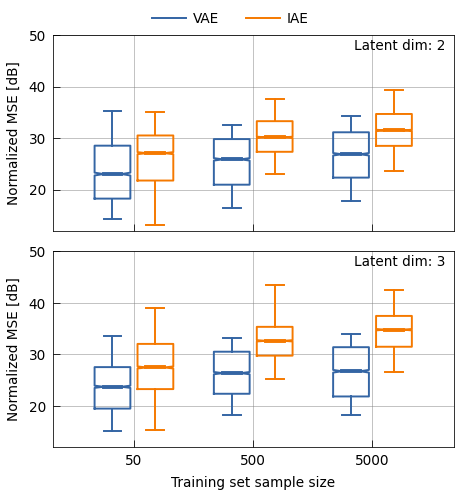

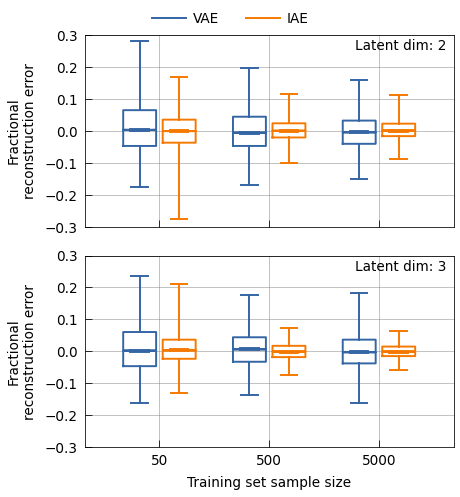

In [18]:
fig1, (axa1, axa2) = plt.subplots(figsize=(3.4,3.5), nrows=2, sharex=True)
fig2, (axb1, axb2) = plt.subplots(figsize=(3.4,3.5), nrows=2, sharex=True)

for axa, axb, latent_dim in zip([axa1, axa2], [axb1, axb2], [2, 3]):
    nmse_VAE = [k.get_reco_nmse_val().flatten() for k in vae_results[latent_dim]]
    ratios_VAE = [k.get_reco_ratio_val().flatten() - 1 for k in vae_results[latent_dim]]
    ratio_IAEu, nmse_IAEu = iae_results[latent_dim]

    props = {'color': psutil.blue}
    bp1 = axa.boxplot(nmse_VAE, sym='', whis=(5, 95), capprops=props, boxprops=props,
                      medianprops={**props, 'lw': 2}, whiskerprops=props,positions=[0.82,1.82,2.82],notch=True)
    props = {'color': psutil.orange}
    bp2 = axa.boxplot(nmse_IAEu, sym='', whis=(5, 95), capprops=props, boxprops=props,
                      medianprops={**props, 'lw': 2}, whiskerprops=props,positions=[1.18,2.18,3.18],notch=True)

    axa.set_ylabel('Normalized MSE [dB]')
    axa.set_xticks([1, 2, 3])
    axa.set_ylim(12, 50)
    axa.set_xticklabels(n_ss)
    axa.text(0.98, 0.98, f'Latent dim: {latent_dim}', transform=axa.transAxes, va='top', ha='right')

#     axa.legend([bp1["boxes"][0], bp2["boxes"][0]], ['VAE', 'IAE'], title=f'Latent dim: {latent_dim}')

    props = {'color': psutil.blue}
    bp1 = axb.boxplot(ratios_VAE, sym='', labels=n_ss, whis=(5, 95), capprops=props, boxprops=props,
                      medianprops={**props, 'lw': 2}, whiskerprops=props,positions=[0.82,1.82,2.82],notch=True)
    props = {'color': psutil.orange}
    bp2 = axb.boxplot(ratio_IAEu, sym='', labels=n_ss, whis=(5, 95), capprops=props, boxprops=props,
                      medianprops={**props, 'lw': 2}, whiskerprops=props,positions=[1.18,2.18,3.18],notch=True)

    axb.set_ylabel('Fractional\nreconstruction error')
    axb.text(0.98, 0.98, f'Latent dim: {latent_dim}', transform=axb.transAxes, va='top', ha='right')
#     axb.legend([bp1["boxes"][0], bp2["boxes"][0]], ['VAE', 'IAE'], title=f'Latent dim: {latent_dim}')
    axb.set_xticks([1, 2, 3])
    axb.set_ylim(-0.3, 0.3)
    axb.set_xticklabels(n_ss)

axa2.set_xlabel('Training set sample size')
axb2.set_xlabel('Training set sample size')
fig1.tight_layout()
fig2.tight_layout()

fig1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['VAE', 'IAE'], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.03))
fig2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['VAE', 'IAE'], ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.03))

fig1.savefig(f'figures/VAE_vs_IAE_NMSE.pdf')
fig2.savefig(f'figures/VAE_vs_IAE_FRE.pdf')

## Reconstruction illustration

For this test, only the AE with latent space = 2 are tested

In [229]:
train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 5000)

latent_dim_iae = 2
latent_dim_vae = 2

fitter = ml_gpr.FitterResult(ml_gpr.VAEFitter.load(model_vae_dir + f'vae_21cmFAST_3params_{latent_dim_vae}_z{z}_n5000_med_beta.pt'), 
                                   train_loader, val_loader) 
rec_vae,dat = fitter.get_recons()

learnfunc = iae.IAE(Model=iae.load_model('IAE_models/'+f'080921_iae_21cmFAST_3params_v2_AP_{latent_dim_iae}_z{z}_n5000_Updated'))
rec_iae = learnfunc.barycentric_span_projection(dat,niter=500)["XRec"]


In [230]:
er = np.linalg.norm((rec_vae-dat) / dat,axis=1)
imin_vae = np.where(er == np.min(er))[0][0]
imedian_vae = np.where(er == np.median(er))[0][0]
imax_vae = np.where(er == np.max(er))[0][0]

er = np.linalg.norm(1 * (rec_iae-dat) / dat,axis=1)
imin_iae = np.where(er == np.min(er))[0][0]
imedian_iae = np.where(er == np.median(er))[0][0]
imax_iae = np.where(er == np.max(er))[0][0]

In [231]:
plt.style.use('/home/users/mertens/.local/share/libwise/mnras2.preset')

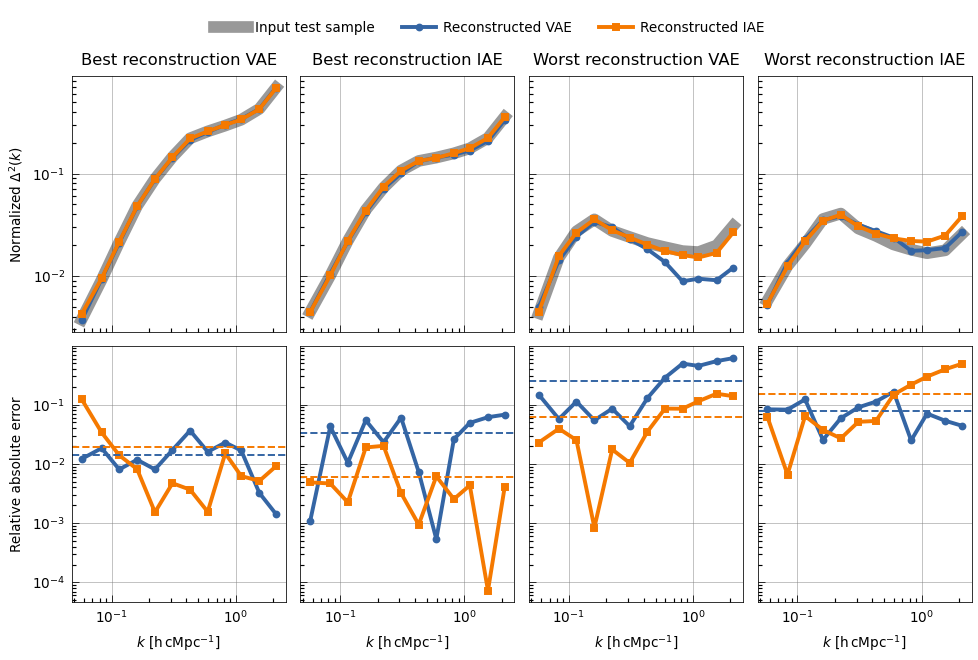

In [232]:
fig, axs = plt.subplots(figsize=(7.1, 4.5), nrows=2, ncols=4, sharex=True, sharey='row')

for i, ax in zip([imin_vae, imin_iae, imax_vae, imax_iae], axs.T):
    ax1, ax2 = ax
    ax1.plot(k_mean, k_mean * dat[i,:], 'k', lw=6, alpha=0.4, label='Input test sample')
    ax1.plot(k_mean, k_mean * rec_vae[i,:], '-o', lw=2, label='Reconstructed VAE', c=psutil.blue)
    ax1.plot(k_mean, k_mean * rec_iae[i,:],'-s',lw=2,label='Reconstructed IAE', c=psutil.orange)

#     ax2.plot(k_mean, k_mean * dat[i,:], 'k', lw=8, alpha=0.3, label='Input test sample')
#     ax2.plot(k_mean, k_mean * abs(rec_vae[i,:]-dat[i]), '-o', lw=2, label='VAE')
#     ax2.plot(k_mean, k_mean * abs(rec_iae[i,:]-dat[i]),'-s',lw=2,label='IAE')
    ax2.plot(k_mean, abs(rec_vae[i,:]-dat[i]) / dat[i], '-o', lw=2, label='VAE', c=psutil.blue)
    ax2.plot(k_mean, abs(rec_iae[i,:]-dat[i]) / dat[i],'-s',lw=2,label='IAE', c=psutil.orange)
    ax2.axhline(np.mean(abs(rec_vae[i,:]-dat[i]) / dat[i]), ls='--', c=psutil.blue)
    ax2.axhline(np.mean(abs(rec_iae[i,:]-dat[i]) / dat[i]), ls='--', c=psutil.orange)

for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_xscale('log')
axs[0][0].set_title('Best reconstruction VAE')
axs[0][1].set_title('Best reconstruction IAE')
axs[0][2].set_title('Worst reconstruction VAE')
axs[0][3].set_title('Worst reconstruction IAE')
axs[1][0].set_ylabel('Relative absolute error')
axs[0][0].set_ylabel('Normalized $\Delta^2(k)$')
for ax in axs[1]:
    ax.set_xlabel('$k\ [\mathrm{h\,cMpc^{-1}}]$')
fig.legend(*ax1.get_legend_handles_labels(), ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.06), borderpad=1.05)
fig.tight_layout()
fig.savefig('figures/reconstruction_residual_best_worst.pdf')